In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [2]:
# this text preprocessor function was originally written by Mauro Di Pietro
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # clean (convert to lowercase and remove punctuations and   
    # characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [3]:
df = pd.read_csv("lyric_bag.csv")
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [4]:
le = preprocessing.LabelEncoder()
X = df['text_clean']
Y = df['cluster']
Y = pd.DataFrame(Y)
# X = pd.DataFrame(X)
Y = Y.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(534,) (534, 1)
(230,) (230, 1)


In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
#vectorizer = CountVectorizer(ngram_range=(1,3))
X_train = vectorizer.fit_transform(X_train.values)
X_test = vectorizer.transform(X_test.values)
print(X_train.shape, X_test.shape)
print(type(X_train),type(X_test))

(534, 94846) (230, 94846)
<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>


In [6]:
Y_train['cluster'].value_counts()

2    134
3    121
1     97
0     94
4     88
Name: cluster, dtype: int64

In [7]:
# %%time
# clf = svm.SVC(C=1, kernel='linear', verbose = True)
# #clf = LinearSVC(C=0.1, max_iter = 10000000)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)

# clf.fit(X_train, Y_train.values.ravel())

# train_acc = cross_val_score(clf, X_train, Y_train.values.ravel(), cv=cv, n_jobs=15).mean()

# Y_predict = clf.predict(X_test)
# test_acc = metrics.accuracy_score(Y_test,Y_predict)

# #test_acc = clf.score(X_test, Y_test.values.ravel())

# print("Training accuracy " + str(train_acc))
# print("Test accuracy " + str(test_acc))

In [8]:
%%time
param = {'C': [1, 10, 100,1000],
              'kernel': ['linear']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)

grid = GridSearchCV(svm.SVC(), param, verbose = 3, cv=cv, return_train_score=True, n_jobs=15)
grid.fit(X_train, Y_train.values.ravel())

Fitting 200 folds for each of 4 candidates, totalling 800 fits
Wall time: 1min 4s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=20, n_splits=10, random_state=None),
             estimator=SVC(), n_jobs=15,
             param_grid={'C': [1, 10, 100, 1000], 'kernel': ['linear']},
             return_train_score=True, verbose=3)

In [9]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'C': 10, 'kernel': 'linear'}
SVC(C=10, kernel='linear')
0.3676729559748428


In [10]:
grid_predict = grid.predict(X_test)
print(metrics.accuracy_score(Y_test,grid_predict))
print(metrics.classification_report(Y_test, grid_predict))

0.3739130434782609
              precision    recall  f1-score   support

           0       0.30      0.24      0.27        41
           1       0.30      0.20      0.24        41
           2       0.43      0.78      0.55        58
           3       0.33      0.33      0.33        52
           4       0.46      0.16      0.24        38

    accuracy                           0.37       230
   macro avg       0.36      0.34      0.32       230
weighted avg       0.37      0.37      0.34       230



In [11]:
# rf_clf = RandomForestClassifier()
# rf_clf = rf_clf.fit(X_train, Y_train.values.ravel())
# model = SelectFromModel(rf_clf, prefit=True)

# # rf_X_train = X_train.loc[:, model.get_support()]
# # rf_X_test = X_test.loc[:, model.get_support()]
# rf_X_train = X_train[:,model.get_support()]
# rf_X_test = X_test[:,model.get_support()]
# print(type(rf_X_train))
# print(rf_X_train.shape)
# #rf_X_train.head()

In [12]:
# %%time
# param = {'C': [1, 10, 100,1000],
#               'kernel': ['linear']}
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)
# grid = GridSearchCV(svm.SVC(), param, verbose = 3, cv=cv, return_train_score=True, n_jobs=15)
# grid.fit(rf_X_train, Y_train.values.ravel())
    
# train_accuracy_svm_rf = grid.best_score_
    
# grid_predict = grid.predict(rf_X_test)
# test_accuracy_svm_rf  = metrics.accuracy_score(Y_test,grid_predict)

# print("Training accuracy " + str(train_accuracy_svm_rf))
# print("Test accuracy " + str(test_accuracy_svm_rf))
# print(grid.best_params_)
# print(metrics.classification_report(Y_test, grid_predict))

In [13]:
X_train2 = pd.DataFrame(X_train.todense(),columns=vectorizer.get_feature_names())
X_test2 = pd.DataFrame(X_test.todense(),columns=vectorizer.get_feature_names())
print(X_train2.shape,X_test2.shape)
pca = PCA()
X_train3 = pca.fit_transform(X_train2)
X_test3 = pca.transform(X_test2)
print(X_train3.shape,X_test3.shape)
print(type(X_train3),type(X_test3))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(534, 94846) (230, 94846)
(534, 534) (230, 534)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [14]:
print(pca.n_components_)
#print(pca.explained_variance_)
#print(pca.explained_variance_ratio_)

534


Text(0, 0.5, 'cumulative explained variance')

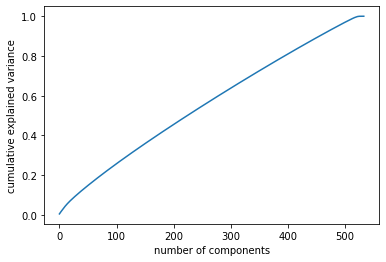

In [15]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


In [16]:
components = np.where(np.cumsum(pca.explained_variance_ratio_) == max(np.cumsum(pca.explained_variance_ratio_)))[0][0]

In [17]:
%%time
pca = PCA(n_components=components)
X_train3 = pca.fit_transform(X_train2)
X_test3 = pca.transform(X_test2)
print(X_train3.shape,X_test3.shape)
print(type(X_train3),type(X_test3))

param = {'C': [0.01,0.1,1, 10, 100,1000],
              'kernel': ['linear']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)

grid = GridSearchCV(svm.SVC(), param, verbose = 3, cv=cv, return_train_score=True, n_jobs=15)
grid.fit(X_train3, Y_train.values.ravel())

print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)


grid_predict = grid.predict(X_test3)
print(metrics.accuracy_score(Y_test,grid_predict))
print(metrics.classification_report(Y_test, grid_predict))

(534, 527) (230, 527)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Fitting 200 folds for each of 6 candidates, totalling 1200 fits
{'C': 10, 'kernel': 'linear'}
SVC(C=10, kernel='linear')
0.365798392732355
0.3739130434782609
              precision    recall  f1-score   support

           0       0.30      0.24      0.27        41
           1       0.30      0.20      0.24        41
           2       0.43      0.78      0.55        58
           3       0.33      0.33      0.33        52
           4       0.46      0.16      0.24        38

    accuracy                           0.37       230
   macro avg       0.36      0.34      0.32       230
weighted avg       0.37      0.37      0.34       230

Wall time: 42.4 s
